In [16]:
import re
import csv
import sqlite3
from pathlib import Path
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from pathlib import Path
from dbManager import DatabaseManager
import pandas as pd 
import numpy as np

all_data_file = Path('activity_data.csv')

manager = DatabaseManager(database_path='activity_data.db')
manager.drop_all()
manager.create()
manager.populate_compounds_table(all_data_file=all_data_file)
manager.populate_assays_table(all_data_file=all_data_file)


manager.get_conn().commit()

df = pd.read_sql_query("SELECT CID, smiles from compounds", manager.get_conn())


# Cluster by Tanimoto similarity 
Alows for horizontal splits of data into 

In [39]:
# compute fingerprint
df['fingerprint'] = df.smiles.apply(lambda x : FingerprintMols.FingerprintMol(Chem.MolFromSmiles(x)))

# hmap = np.empty(shape=(len(df),len(df)))
# table=pd.DataFrame()
# # work out pair-wise similiarity
# for index, i in enumerate(df.fingerprint):
#     for jndex, j in enumerate (df.fingerprint):
#         similarity = DataStructs.FingerprintSimilarity(i,j)
#         hmap[index,jndex] = similarity
#         table.loc[df.CID[index],df.CID[jndex]] = similarity


In [44]:
table.to_pickle("pandas_dumps/similarity_matrix.pkl")


# Load in pre-computed clusters

In [52]:
#Define clustering setup
def ClusterFps(fps,cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs


# Clustering
Investigating the effect of cutoff on number of clusters generated.
Using Butina clustering.
Will use a cutoff of 0.5 which gives 32 clusters.


In [61]:
cutoffs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cutoff_clusters = []
for cutoff in cutoffs:
    cutoff_clusters.append(ClusterFps(df.fingerprint.tolist(), cutoff=cutoff))
n_clusters = list(len(x) for x in cutoff_clusters)
import matplotlib.pyplot as plt


[1190, 788, 567, 377, 32, 1, 1, 1, 1]


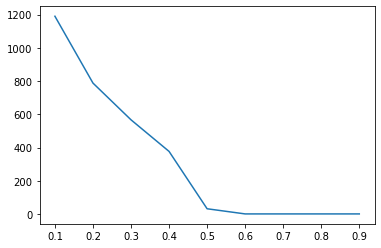

In [68]:
plt.plot(cutoffs,n_clusters)
print(n_clusters)

In [95]:
clusters_0_5 = cutoff_clusters[4]
print(clusters_0_5)
def find_cluster(clusters, item):
    for i, cluster in enumerate(clusters):
        if item.name in cluster:
            return i
# write cluster number of pandas df
df['cluster'] = df.index.map(lambda x: find_cluster(clusters_0_5,x))
df['cluster'] = df['cluster'].astype("int64")
df.describe()

((1620, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 200, 201, 202, 203, 205, 208, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 2

,cluster
count,2037.000000
mean,0.489445
std,2.524246
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,31.000000


In [97]:
df.cluster.describe()

AttributeError: 'Int64Index' object has no attribute 'describe'